In [16]:
import tensorflow as tf
from utils import *
import requests,re

In [23]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Defined in :numref:`sec_text-sequence`"""
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']
    
class TimeMachine(DataModule):
    """The Time Machine dataset.
    Defined in :numref:`sec_text-sequence`"""
    def _download(self):
        r = requests.get(DATA_URL + 'timemachine.txt', stream=True, verify=True)
        with open('./data/timemachine.txt', 'wb') as f:
            f.write(r.content)
        return r.content.decode('utf-8')

    def _preprocess(self, text):
        """Defined in :numref:`sec_text-sequence`"""
        return re.sub('[^A-Za-z]+', ' ', text).lower()

    def _tokenize(self, text):
        """Defined in :numref:`sec_text-sequence`"""
        return list(text)

    def build(self, raw_text, vocab=None):
        """Defined in :numref:`sec_text-sequence`"""
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None: vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

    def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
        """Defined in :numref:`sec_language-model`"""
        super(TimeMachine, self).__init__()
        self.save_hyperparameters()
        corpus, self.vocab = self.build(self._download())
        array = tf.constant([corpus[i:i+num_steps+1]
                            for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:,:-1], array[:,1:]

    def get_dataloader(self, train):
        """Defined in :numref:`subsec_partitioning-seqs`"""
        idx = slice(0, self.num_train) if train else slice(
            self.num_train, self.num_train + self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)


In [68]:
class RNNLMScratch(Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = tf.Variable(tf.random.normal(
            (self.rnn.num_hiddens, self.vocab_size)) * self.rnn.sigma)
        self.b_q = tf.Variable(tf.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', tf.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', tf.exp(l), train=False)
        
    def output_layer(self, rnn_outputs):
        outputs = [tf.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return tf.stack(outputs, 1)

    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    
    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return tf.one_hot(tf.transpose(X), self.vocab_size)

    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = tf.constant([[outputs[-1]]])
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                self.Y_ = Y
                outputs.append(int(tf.reshape(tf.argmax(Y, axis=2), 1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

# RNN Concise Implementation

In [69]:
class RNNKeras(Module):
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        # Fully-connected RNN where the output is to be fed back to input.
        self.rnn = tf.keras.layers.SimpleRNN(num_hiddens, return_sequences=True, return_state=True, time_major=True)
        
    def forward(self, X, H=None):
        outputs, H = self.rnn(X, H)
        return outputs, H

In [80]:
class RNNLMKeras(RNNLMScratch):
    def init_params(self):
        self.linear = tf.keras.layers.Dense(self.vocab_size)
        
    def output_layer(self, hiddens):
        return tf.transpose(self.linear(hiddens), (1,0,2))

In [81]:
data = TimeMachine(batch_size=1024,num_steps=32)
rnn = RNNKeras(num_hiddens=32)
model = RNNLMKeras(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

'it hasgzhbgnhvxxgnhvxxdwvk'

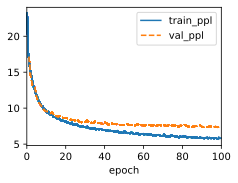

In [82]:
with try_gpu():
    trainer = Trainer(max_epochs=100, gradient_clip_val=1)
    trainer.fit(model, data)

In [78]:
model.predict('it has', 20, data.vocab)

'it has an the the the the '

## Backpropagation Through Time